# Problem Statement

1. Scrape approximately 1000 comments/reviews from Twitter/Instagram of Any
Product Manufacturing Company

2. Develop **Unsupervised** Sentiment Analysis model to predict **"Positive"**, **"Slightly Positive"**, **"Neutral"**, **"Slightly Negative"** or **"Negative"** for each comment/review. 

3. Submit Python/R Software for Scrapping and Model Building. 



## Import Libraries

In [174]:
import tweepy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier



from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

## Getting API Keys and Access Tokens

Connecting with the Twitter Server application from a client application such as Python, we need consumer API keys and Access tokens

![picture](https://drive.google.com/uc?export=view&id=1B646zJKIByrFYwUetxUA55thVbikqaVq)

In [175]:
consumer_key = 'Fnd9AAdBBn7DiohIdVDHAjbID'
consumer_secret = 'ogbboFLndF52HSm83y0Iqp92FJ4ZUrbB0F2XfHht3VP84ufkAf' 
access_token = '2601458342-Tp6HheOUzhYY6lQdxAKmrDB2z10Nse0PeV3eYx8'
access_token_secret ='auCntDSiZPUQqtsQRZUN0r7IAeWduFWaRPmUuW7F3VGt7'

## Fetch Tweets (Twitter API using 'TweePy')

In [176]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

### Here, we are fetching tweets for 'Tesla' a Car Manufacturing Company 

In [177]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('Tesla', maxTweets=1500)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 584 tweets
Downloaded 677 tweets
Downloaded 777 tweets
Downloaded 877 tweets
Downloaded 977 tweets
Downloaded 1077 tweets
Downloaded 1177 tweets
Downloaded 1277 tweets
Downloaded 1377 tweets
Downloaded 1477 tweets
Downloaded 1577 tweets
tweets_df Shape - (1115, 1)


,tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open..."
5,https://t.co/NChgz9mmqb\n@Tesla $TSLA $NIO $TC...
6,RT @Luis_I_Gomez: Pobres ricos! Les vana freír...
7,RT @JonErlichman: Things that didn’t exist the...
8,@themouthmatusow Yeah right mike you were at o...
9,@VGrinshpun @FdsPhilippe @bizandsec @dividendg...


So, there are almost 1000+ recent tweets scrapped from **Twitter**

## Text Pre-Processing 

### A. Pre-Processing 'Key Words'

#### a. Removing '@names'  

Here, we can see that at many places we have '@names', which is of no use since it does not have any meaning, So it needs to be removed.

In [178]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [179]:
# We are keeping cleaned tweets in a new column called 'clean_tweets'

tweets_df['clean_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], " *RT* | *@[\w]*")

tweets_df.head(10)

,tweets,clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.\nhttps://t.co/i30ulDptDq\n https://t.co...
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,… https://t.co/1xPXGvmCvH
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs..."
5,https://t.co/NChgz9mmqb\n@Tesla $TSLA $NIO $TC...,https://t.co/NChgz9mmqb\n $TSLA $NIO $TCEHY $R...
6,RT @Luis_I_Gomez: Pobres ricos! Les vana freír...,: Pobres ricos! Les vana freír!\n\nMenos mal q...
7,RT @JonErlichman: Things that didn’t exist the...,: Things that didn’t exist the last time the D...
8,@themouthmatusow Yeah right mike you were at o...,Yeah right mike you were at our executive boa...
9,@VGrinshpun @FdsPhilippe @bizandsec @dividendg...,… https://t.co/oLQHputORO


So, now we don't have '@name' values in clean_tweets

#### b. Removing Links (http|https)

In [180]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.clean_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['clean_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs..."
5,https://t.co/NChgz9mmqb\n@Tesla $TSLA $NIO $TC...,$TSLA $NIO $TCEHY $RACE $JPM
6,RT @Luis_I_Gomez: Pobres ricos! Les vana freír...,: Pobres ricos! Les vana freír! Menos mal que ...
7,RT @JonErlichman: Things that didn’t exist the...,: Things that didn’t exist the last time the D...
8,@themouthmatusow Yeah right mike you were at o...,Yeah right mike you were at our executive boar...
9,@VGrinshpun @FdsPhilippe @bizandsec @dividendg...,…


#### c. Removing tweets with empty text 

In [181]:
tweets_df = tweets_df[tweets_df['clean_tweets']!='']
tweets_df.head()

,tweets,clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs..."


#### d. Dropping duplicate rows 

In [182]:
tweets_df.drop_duplicates(subset=['clean_tweets'], keep=False)
tweets_df.head()

,tweets,clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs..."


#### e. Resetting Index 

Index needs to be reset, since after removal of some rows, some index values are missing, which may cause problem in future operations

In [183]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs..."


#### f. Removing Punctuations, Numbers and Special Characters  

This step optional, if we want to do sentiment analysis on key phrases as well, because semantic meaning in a sentence needs to be present. So, here we will create one additional column 'absolute_clean_tweets' which will contain absolute clean words which can be further used for sentiment analysis on key words.

In [184]:
tweets_df['absolute_clean_tweets'] = tweets_df['clean_tweets'].str.replace("[^a-zA-Z# ]", "")

In [185]:
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...,Elon Musk Tesla Elon Musk
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...,cancelled the #Tesla order given the situati...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.,Cool
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…,
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs...",Exactly years ago #Tesla opened its first fa...


#### g. Removal of Stop Words 

With the same reason as mentioned above, we won't perform this on 'clean_tweets' column, because it needs to be used for key_phrases sentiment analysis.

In [186]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [187]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [188]:
tweets_df['absolute_clean_tweets'] = tweets_df['absolute_clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words())]))
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...,Elon Musk Tesla Elon Musk
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...,cancelled #Tesla order given situation #Artsak...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.,Cool
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…,
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs...",Exactly years ago #Tesla opened first factory ...


In [189]:
tweets_df = tweets_df.dropna()

In [190]:
tweets_df.head(10)

,tweets,clean_tweets,absolute_clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...,Elon Musk Tesla Elon Musk
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...,cancelled #Tesla order given situation #Artsak...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.,Cool
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…,
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs...",Exactly years ago #Tesla opened first factory ...
5,https://t.co/NChgz9mmqb\n@Tesla $TSLA $NIO $TC...,$TSLA $NIO $TCEHY $RACE $JPM,TSLA NIO TCEHY RACE JPM
6,RT @Luis_I_Gomez: Pobres ricos! Les vana freír...,: Pobres ricos! Les vana freír! Menos mal que ...,Pobres ricos Les vana frer Menos mal pobres ll...
7,RT @JonErlichman: Things that didn’t exist the...,: Things that didn’t exist the last time the D...,Things didnt exist last time Dodgers World Ser...
8,@themouthmatusow Yeah right mike you were at o...,Yeah right mike you were at our executive boar...,Yeah right mike executive board meeting last n...
9,@VGrinshpun @FdsPhilippe @bizandsec @dividendg...,…,


#### h. Tokenize absolute_clean_tweets 

In [191]:
tokenized_tweet = tweets_df['absolute_clean_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0                      [Elon, Musk, Tesla, Elon, Musk]
1    [cancelled, #Tesla, order, given, situation, #...
2                                               [Cool]
3                                                   []
4    [Exactly, years, ago, #Tesla, opened, first, f...
Name: absolute_clean_tweets, dtype: object

#### i. Converting words into Lemma 

In [192]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [193]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0                      [Elon, Musk, Tesla, Elon, Musk]
1    [cancelled, #Tesla, order, given, situation, #...
2                                               [Cool]
3                                                   []
4    [Exactly, year, ago, #Tesla, opened, first, fa...
Name: absolute_clean_tweets, dtype: object

#### i. Joining all tokens into sentences 

In [194]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_clean_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,clean_tweets,absolute_clean_tweets
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...,Elon Musk Tesla Elon Musk
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...,cancelled #Tesla order given situation #Artsak...
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.,Cool
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…,
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs...",Exactly year ago #Tesla opened first factory T...
5,https://t.co/NChgz9mmqb\n@Tesla $TSLA $NIO $TC...,$TSLA $NIO $TCEHY $RACE $JPM,TSLA NIO TCEHY RACE JPM
6,RT @Luis_I_Gomez: Pobres ricos! Les vana freír...,: Pobres ricos! Les vana freír! Menos mal que ...,Pobres rico Les vana frer Menos mal pobres lle...
7,RT @JonErlichman: Things that didn’t exist the...,: Things that didn’t exist the last time the D...,Things didnt exist last time Dodgers World Ser...
8,@themouthmatusow Yeah right mike you were at o...,Yeah right mike you were at our executive boar...,Yeah right mike executive board meeting last n...
9,@VGrinshpun @FdsPhilippe @bizandsec @dividendg...,…,


## Data Visualization 

We will see the most common words in Positive and Negative tweets using WordCloud and TextBlob for Visualization purpose only  

In [195]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [196]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [197]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,977
neg,123


In [198]:
tweets_df['Type'] = sentiments_using_textblob
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets,Type
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...,Elon Musk Tesla Elon Musk,pos
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...,cancelled #Tesla order given situation #Artsak...,pos
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.,Cool,pos
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…,,pos
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs...",Exactly year ago #Tesla opened first factory T...,pos


In [199]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

**Most common words in Positive tweets**

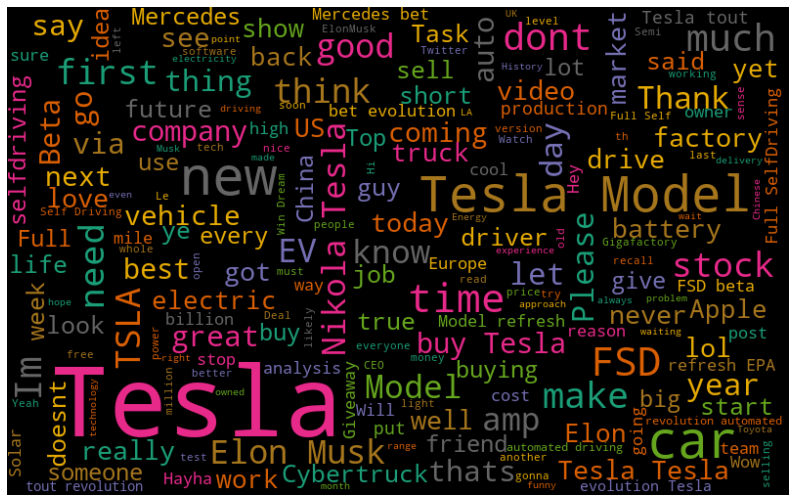

In [200]:
all_words = ' '.join([text for text in tweets_df['absolute_clean_tweets'][tweets_df.Type == 'pos']])
generate_wordcloud(all_words)

**Most common words in Negative Tweets**

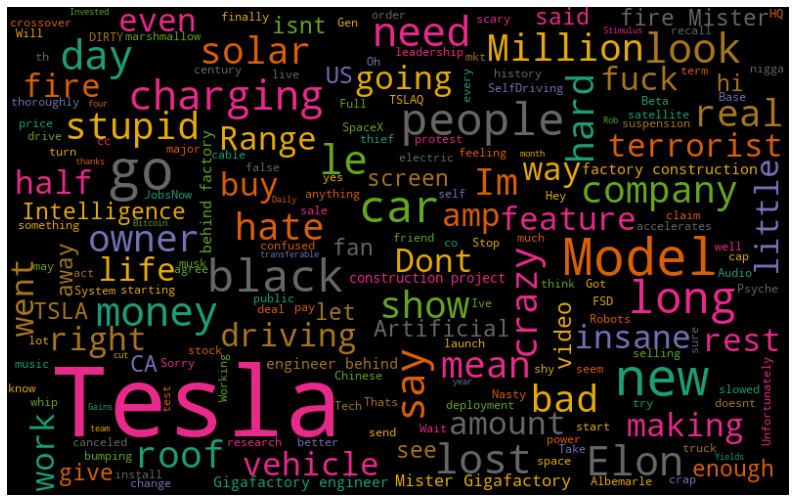

In [201]:
all_words = ' '.join([text for text in tweets_df['absolute_clean_tweets'][tweets_df.Type == 'neg']])
generate_wordcloud(all_words)




*   Tesla, Elon, Car and Model have clearly been used in both positive and negative tweets, which is very obvious and shows it is car manufacturing company. 
*   In positive tweets, Revolution, Evolution, EV, Self-Driving etc. are the buzz words and shows that it is a technology driven company. 

*   However, in negative tweets we can see negative words like bad, stupid, false, behind etc. 




Most commonly used **HASHTAGS** 

In [202]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags  
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()
    

In [203]:
hashtags = hashtag_extract(tweets_df['clean_tweets'])
hashtags = sum(hashtags, [])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32654 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_

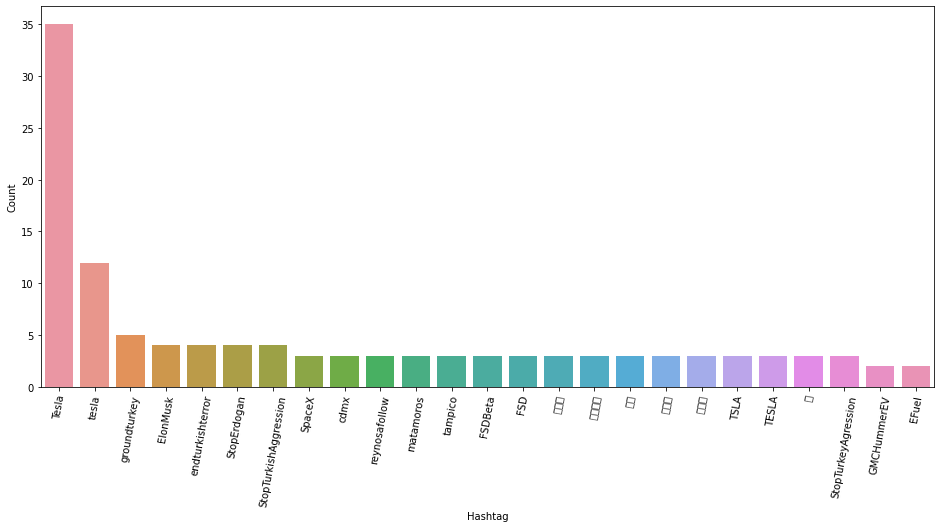

In [204]:
generate_hashtag_freqdist(hashtags)

As expected, here we can see Tesla, tesla and Elon Musk are the most common hashtags. But, there is another hashtag which is quite popular and in news these days ie. **FSDBeta** 

![picture](https://drive.google.com/uc?export=view&id=1B3_TgRAKx1ZTlV9cnrmgN8zZtC8VLfPg)

## Model Building (Unsupervised)

There are two major techniques for Sentiment Analsysis:- 



*   Supervised 
*   Unsupervised (Lexicon Based) 

Unsupervised way is generally useful when we do not have the convenience of well-labeled training dataset.

Here, I try to use unsupervised lexicon based approach based on **Vader lexicon** for sentiment analysis.



In [205]:
!pip install vaderSentiment

In [206]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [207]:
tweets_df = tweets_df.drop(['Type'], axis = 1)

In [208]:
tweets_df['Compound_Score'] = [analyser.polarity_scores(x)['compound'] for x in tweets_df['clean_tweets']]

In [209]:
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...,Elon Musk Tesla Elon Musk,0.0000
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...,cancelled #Tesla order given situation #Artsak...,-0.5037
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.,Cool,0.3182
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…,,0.0000
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs...",Exactly year ago #Tesla opened first factory T...,0.3818


Check **Range** of Compound Score 

In [210]:
tweets_df.nlargest(10, ['Compound_Score']) 

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score
15,RT @PodemosFuerza: Valdrá la pena esperar........,: Valdrá la pena esperar..... Yo quiero un #Te...,Valdr pena esperar Yo quiero #Tesla Model S co...,0.9913
801,@Tesla Attention: KID ROCK is now accepting ...,Attention: KID ROCK is now accepting new corpo...,Attention KID ROCK accepting new corporate spo...,0.9709
793,RT @Cava_no_kanzume: #ハリーポッター 放送してたんだ😮✨良いなぁ💕\n...,: #ハリーポッター 放送してたんだ😮✨良いなぁ💕 前にLAのユニバーサルスタジオで 楽しそ...,# LA,0.9595
718,@elonmusk sir you scare me. Ahaha but please g...,sir you scare me. Ahaha but please give me a T...,sir scare Ahaha please give Tesla,0.9593
707,Yes this is @elonmusk car @Tesla is doing gre...,"Yes this is car is doing great, 🤣🤣🤣",Yes car great,0.9468
924,@mikebreslin815 @ladygaga That’s a Model X Tes...,That’s a Model X Tesla.. yeah.. nice ride..✨😎🔋...,Thats Model X Tesla yeah nice ride,0.9274
583,RT @castellanosce_: 👩‍🦰 🥰 🦒 🧡\nhttps://t.co/...,: 👩‍🦰 🥰 🦒 🧡,,0.9100
103,@LicketySpliket @jailbroke_tesla @WhiteHo80803...,That is very good idea. Very user friendly and...,That good idea Very user friendly clean Thanks,0.9056
364,it's funny bc last year i thought they cared a...,it's funny bc last year i thought they cared a...,funny bc last year thought cared usbut looking...,0.9014
614,WHAAAAT @elonmusk ? Just saw this...\nIt’s FUN...,WHAAAAT ? Just saw this... It’s FUNNY. Not wha...,WHAAAAT Just saw Its FUNNY Not said No funny b...,0.8916


In [211]:
tweets_df.nsmallest(10, ['Compound_Score']) 

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score
565,DeBRA cox warm but am rate my performance caus...,DeBRA cox warm but am rate my performance caus...,DeBRA cox warm rate performance cause I TRICKE...,-0.9231
66,@miguelhilario_ Dude I knowwwwww it’s crazy di...,Dude I knowwwwww it’s crazy disgusting!!!! The...,Dude I knowwwwww crazy disgusting They say Tes...,-0.8902
727,@TheSecretLawofA eddison was not a genius! he ...,"eddison was not a genius! he was a fake, lame,...",eddison genius fake lame cheater He never real...,-0.8745
800,RT @nhonickman: #Rogue @Enter_Apps with new up...,: #Rogue with new update Tesla icon 🔥🔥🔥🔥 #Orsa...,#Rogue new update Tesla icon #Orsam old school...,-0.8225
52,RT @noonarut: “Don’t send terrorists to space”...,: “Don’t send terrorists to space” protest at ...,Dont send terrorist space protest #SpaceX HQ S...,-0.8221
534,“Don’t send terrorists to space” protest at #S...,“Don’t send terrorists to space” protest at #S...,Dont send terrorist space protest #SpaceX HQ S...,-0.8221
121,@LicketySpliket @jailbroke_tesla @WhiteHo80803...,This UI goes crazy. Always hated how confusing...,This UI go crazy Always hated confusing run,-0.8176
1062,RT @CodingMark: Lmao 😂 Sweat the car thieves o...,: Lmao 😂 Sweat the car thieves out! 🥵🔥🔥🔥 Tesla...,Lmao Sweat car thief Tesla Model owner cleverl...,-0.7959
467,@Goal__Diggah A Tesla so random niggas can say...,A Tesla so random niggas can say you don’t own...,A Tesla random nigga say dont black woman nigg...,-0.7832
365,"@aminorjourney Uh oh, she’s gonna say somethin...","Uh oh, she’s gonna say something bad about Tes...",Uh oh shes gonna say something bad Tesla Or ma...,-0.7777


**Compund Score** is the most powerful metric for single unidimensional measure of sentiment for a given sentence. It is a 'normalized, weighted composite score computed by summing the valence scores of each word in lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1(most extreme positive) 

In [212]:
tweets_df.loc[tweets_df['Compound_Score'] < -0.5, 'Sentiments'] = 'Negative' 
tweets_df.loc[(tweets_df['Compound_Score'] >= -0.5) & (tweets_df['Compound_Score'] < 0) , 'Sentiments'] = 'Slightly Negative' 
tweets_df.loc[tweets_df['Compound_Score'] == 0 , 'Sentiments'] = 'Neutral'
tweets_df.loc[(tweets_df['Compound_Score'] > 0) & (tweets_df['Compound_Score'] < 0.5), 'Sentiments'] = 'Slightly Positive'
tweets_df.loc[tweets_df['Compound_Score'] > 0.5 , 'Sentiments'] = 'Postive'
tweets_df

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score,Sentiments
0,RT @xbzzbz: มีคนถาม Elon Musk ว่า โลโก้ Tesla ...,: มีคนถาม Elon Musk ว่า โลโก้ Tesla นี่คือจมูก...,Elon Musk Tesla Elon Musk,0.0000,Neutral
1,RT @alexiemay: @elonmusk cancelled the #Tesla ...,: cancelled the #Tesla order - given the situa...,cancelled #Tesla order given situation #Artsak...,-0.5037,Negative
2,@elonmusk Cool.\nhttps://t.co/i30ulDptDq\n@elo...,Cool.,Cool,0.3182,Slightly Positive
3,@WholeMarsBlog @kimpaquette @vincent13031925 @...,…,,0.0000,Neutral
4,"RT @EvaFoxU: Exactly 10 years ago, #Tesla open...",": Exactly 10 years ago, #Tesla opened its firs...",Exactly year ago #Tesla opened first factory T...,0.3818,Slightly Positive
...,...,...,...,...,...
1095,RT @MarketRebels: Gene Munster says that $TSLA...,": Gene Munster says that $TSLA is, ""crushing t...",Gene Munster say TSLA crushing competition He ...,-0.3612,Slightly Negative
1096,@elonmusk I know this showboating but great mi...,I know this showboating but great mids must EQ...,I know showboating great mids must EQ prematur...,0.7684,Postive
1097,"@Out_of_Spec given guidelines by your friend, ...","given guidelines by your friend, or by tesla?",given guideline friend tesla,0.4939,Slightly Positive
1098,"#Tesla did unveil its new electric Semi, if y...","#Tesla did unveil its new electric Semi, if yo...",#Tesla unveil new electric Semi ask,0.0000,Neutral


In [213]:
tweets_df.to_csv('file.csv') 

**Some Interesting follow up to explore :**

1. Explore the text data more with the help of different kinds of visualisation eg. Sentiment Polarity Distribution, Text length distribution, Word Count Distribution, N-Gram Distribution etc. 

2. Sentiment Analysis with other Unsupervised Methods / Models such as KMeans etc. 

3. Finally, it can be interesting to see the performance of these different unsupervised approaches on the same dataset. 